In [ ]:
! pip install opendatasets

In [ ]:
#===============================
# Step-1: import libraries
#===============================


import warnings
warnings.filterwarnings('ignore')
import opendatasets as od

import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Dropout,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
## {"username":"chanchalsaha7","key":"9ae140efdb070deb48f1b8effc11f3d5"}

In [ ]:
link='https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images'
od.download(link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: chanchalsaha7
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images


100%|██████████| 3.10G/3.10G [00:30<00:00, 109MB/s] 


In [ ]:
#====================================================
#Step-2: load Dataset and Create a Dataframe
#===================================================

base_dir='/content/breast-histopathology-images'

pattern=os.path.join(base_dir,'**',"*.png")

filepaths=glob.glob(pattern,recursive=True)

label=[]

for file in filepaths:
  label.append(os.path.basename(os.path.dirname(file)))

df=pd.DataFrame({
    'path':filepaths,
    'label':label
})
df.head()


,path,label
0,/content/breast-histopathology-images/9178/0/9...,0
1,/content/breast-histopathology-images/9178/0/9...,0
2,/content/breast-histopathology-images/9178/0/9...,0
3,/content/breast-histopathology-images/9178/0/9...,0
4,/content/breast-histopathology-images/9178/0/9...,0


In [ ]:
# =====================================================
# Step-3: Train-test-split
#=====================================================
train_df,valtest_df=train_test_split(df,test_size=0.3,random_state=42,stratify=df['label'])
val_df,test_df=train_test_split(valtest_df,test_size=0.5,random_state=42,stratify=valtest_df['label'])

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(388533, 2)
(83258, 2)
(83257, 2)


In [ ]:
# =====================================================
# Step-4: Data Generators
# =====================================================
Datagen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

Datagen2=ImageDataGenerator(
    rescale=1./255
)

In [ ]:
IMG_SIZE=(50,50)
BATCH_SIZE=16
EPOCHS=5

In [ ]:
train_gen=Datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='label',
    batch_size=BATCH_SIZE,
    seed=42,
    target_size=IMG_SIZE,
    shuffle=True,
    class_mode='binary'
)

Found 388533 validated image filenames belonging to 2 classes.


In [ ]:
val_gen=Datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='label',
    batch_size=BATCH_SIZE,
    seed=42,
    target_size=IMG_SIZE,
    shuffle=False,
    class_mode='binary'
)

Found 83257 validated image filenames belonging to 2 classes.


In [ ]:
test_gen=Datagen.flow_from_dataframe(
    test_df,
    x_col='path',
    y_col='label',
    batch_size=BATCH_SIZE,
    seed=42,
    target_size=IMG_SIZE,
    shuffle=False,
    class_mode='binary'
)

Found 83258 validated image filenames belonging to 2 classes.


In [ ]:
# =====================================================
# Step-5: Transfer Learning Model
# =====================================================
base_model=EfficientNetB0(include_top=False,weights='imagenet',input_shape=IMG_SIZE+(3,))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [ ]:
base_model.trainable=False


In [ ]:
model=Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(1,activation='sigmoid')
])

In [ ]:
model.compile(
    optimizer=Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [ ]:
checkpoint_cb=ModelCheckpoint('bestmodel.h5',save_best_only=True)
earlystop_cb=EarlyStopping(
    patience=3,
    restore_best_weights=True
)

In [ ]:
# =====================================================
# Step-6: Train Frozen Model (Baseline)
# =====================================================

history=model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb,earlystop_cb]
)

Epoch 1/5
24284/24284 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7147 - loss: 0.6052

24284/24284 ━━━━━━━━━━━━━━━━━━━━ 961s 38ms/step - accuracy: 0.7147 - loss: 0.6052 - val_accuracy: 0.7161 - val_loss: 0.5900
Epoch 2/5
24284/24284 ━━━━━━━━━━━━━━━━━━━━ 797s 33ms/step - accuracy: 0.7152 - loss: 0.6023 - val_accuracy: 0.7161 - val_loss: 0.5993
Epoch 3/5
24283/24284 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7141 - loss: 0.6038

24284/24284 ━━━━━━━━━━━━━━━━━━━━ 749s 31ms/step - accuracy: 0.7141 - loss: 0.6038 - val_accuracy: 0.7161 - val_loss: 0.5894
Epoch 4/5
24284/24284 ━━━━━━━━━━━━━━━━━━━━ 737s 30ms/step - accuracy: 0.7149 - loss: 0.6023 - val_accuracy: 0.7161 - val_loss: 0.5954
Epoch 5/5
24284/24284 ━━━━━━━━━━━━━━━━━━━━ 731s 30ms/step - accuracy: 0.7143 - loss: 0.6023 - val_accuracy: 0.7161 - val_loss: 0.6346


In [ ]:
#===================================
# Step-7: Evaluation
#===================================
loss,acc =model.evaluate(test_gen)
print(f'Test Accuracy: {acc*100:.2f}%')



5204/5204 ━━━━━━━━━━━━━━━━━━━━ 139s 27ms/step - accuracy: 0.7157 - loss: 0.5898
Test Accuracy: 71.61%


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report


5204/5204 ━━━━━━━━━━━━━━━━━━━━ 130s 25ms/step


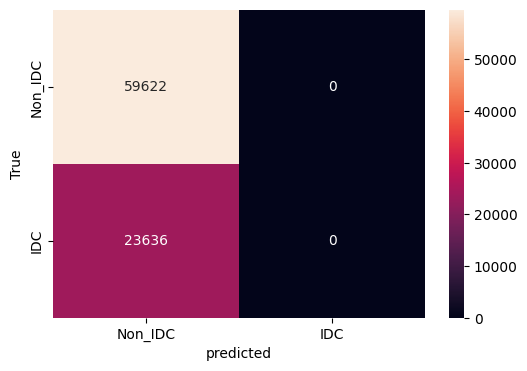

              precision    recall  f1-score   support

     Non_IDC       0.72      1.00      0.83     59622
         IDC       0.00      0.00      0.00     23636

    accuracy                           0.72     83258
   macro avg       0.36      0.50      0.42     83258
weighted avg       0.51      0.72      0.60     83258



In [ ]:


# Confusion matrix
y_true=test_gen.classes
y_pred=(model.predict(test_gen)>0.5).astype('int32').flatten()

cm=confusion_matrix(y_true,y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=['Non_IDC','IDC'],yticklabels=['Non_IDC','IDC'])
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()


 # classification report
print(classification_report(y_true,y_pred,target_names=['Non_IDC','IDC']))




In [ ]:
# =====================================================
# Step-8: Fine Tuning (Unfreeze last layers)
# =====================================================
from tensorflow.keras.callbacks import ReduceLROnPlateau

base_model.trainable=True

# fine-tune only last 50 layers

for layer in base_model.layers[:-50]:
  layer.trainable=False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

fine_tune_callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.5, patience=3),
    ModelCheckpoint("EfficientNetB0_finetuned.h5", save_best_only=True)
]

In [ ]:
from sklearn.utils import class_weight
import numpy as np

y_train = train_gen.classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)



Class Weights: {0: np.float64(0.6982151649876183), 1: np.float64(1.7612556663644605)}


In [ ]:
h2=model.fit(
    train_gen,
    validation_data=val_gen,
    callbacks=fine_tune_callbacks,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
24284/24284 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5887 - loss: 0.6791

24284/24284 ━━━━━━━━━━━━━━━━━━━━ 1016s 41ms/step - accuracy: 0.5887 - loss: 0.6791 - val_accuracy: 0.4730 - val_loss: 0.7394 - learning_rate: 1.0000e-05
Epoch 2/10
24283/24284 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6631 - loss: 0.6072

24284/24284 ━━━━━━━━━━━━━━━━━━━━ 890s 37ms/step - accuracy: 0.6631 - loss: 0.6072 - val_accuracy: 0.7256 - val_loss: 0.5024 - learning_rate: 1.0000e-05
Epoch 3/10
24284/24284 ━━━━━━━━━━━━━━━━━━━━ 852s 35ms/step - accuracy: 0.6922 - loss: 0.5816 - val_accuracy: 0.7150 - val_loss: 0.6969 - learning_rate: 1.0000e-05
Epoch 4/10
24284/24284 ━━━━━━━━━━━━━━━━━━━━ 818s 34ms/step - accuracy: 0.7058 - loss: 0.5670 - val_accuracy: 0.7157 - val_loss: 1.0118 - learning_rate: 1.0000e-05
Epoch 5/10
24284/24284 ━━━━━━━━━━━━━━━━━━━━ 790s 33ms/step - accuracy: 0.7138 - loss: 0.5587 - val_accuracy: 0.7152 - val_loss: 0.7548 - learning_rate: 1.0000e-05
Epoch 6/10
24284/24284 ━━━━━━━━━━━━━━━━━━━━ 772s 32ms/step - accuracy: 0.7277 - loss: 0.5446 - val_accuracy: 0.7147 - val_loss: 0.8791 - learning_rate: 5.0000e-06
Epoch 7/10
24284/24284 ━━━━━━━━━━━━━━━━━━━━ 769s 32ms/step - accuracy: 0.7338 - loss: 0.5384 - val_accuracy: 0.7158 - val_loss: 1.1052 - learning_rate: 5.0000e-06


5204/5204 ━━━━━━━━━━━━━━━━━━━━ 132s 25ms/step - accuracy: 0.7247 - loss: 0.5031
Test Accuracy: 72.51%
5204/5204 ━━━━━━━━━━━━━━━━━━━━ 125s 24ms/step


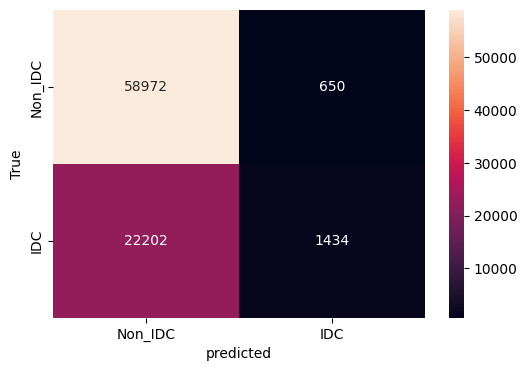

              precision    recall  f1-score   support

     Non_IDC       0.73      0.99      0.84     59622
         IDC       0.69      0.06      0.11     23636

    accuracy                           0.73     83258
   macro avg       0.71      0.52      0.47     83258
weighted avg       0.72      0.73      0.63     83258



In [41]:
#========================================
# Step-9: Fine Tunning Model Evaluation
#========================================
loss,acc =model.evaluate(test_gen)
print(f'Test Accuracy: {acc*100:.2f}%')

 # Confusion matrix
y_true=test_gen.classes
y_pred=(model.predict(test_gen)>0.5).astype('int32').flatten()

cm=confusion_matrix(y_true,y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm,annot=True,fmt='d',xticklabels=['Non_IDC','IDC'],yticklabels=['Non_IDC','IDC'])
plt.xlabel('predicted')
plt.ylabel('True')
plt.show()


 # classification report
print(classification_report(y_true,y_pred,target_names=['Non_IDC','IDC']))



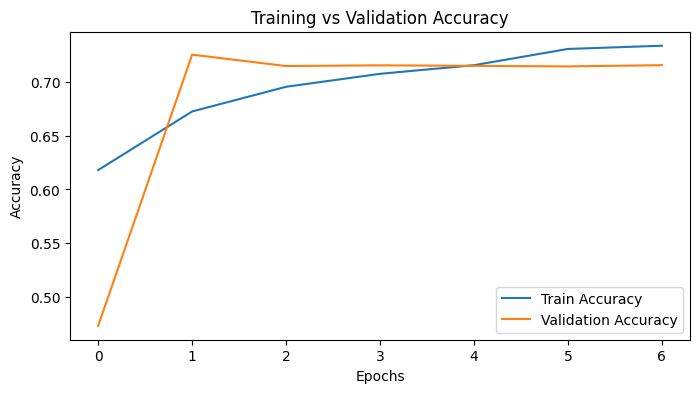

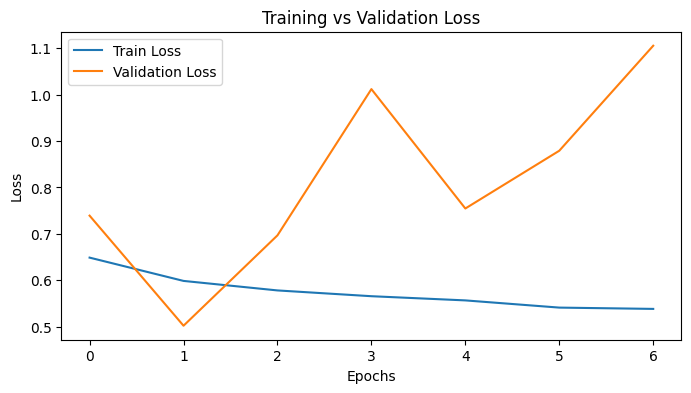

In [42]:
# Training & Validation Accuracy
plt.figure(figsize=(8,4))
plt.plot(h2.history['accuracy'], label='Train Accuracy')
plt.plot(h2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

# Training & Validation Loss
plt.figure(figsize=(8,4))
plt.plot(h2.history['loss'], label='Train Loss')
plt.plot(h2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()